# Singlestep Forecasting

## Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

import xgboost

## Load Data

In [2]:
# load dataset
data = pd.read_csv("portfolio_data.csv")

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1520, 5)


,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285


In [3]:
data.Date = pd.to_datetime(data.Date)

In [4]:
data = data.set_index("Date")

In [5]:
AMZN_df = data[["AMZN"]].rename(columns={"AMZN":"price"})
DPZ_df = data[["DPZ"]].rename(columns={"DPZ":"price"})
BTC_df = data[["BTC"]].rename(columns={"BTC":"price"})
NFLX_df = data[["NFLX"]].rename(columns={"NFLX":"price"})

## Feature Engineering

In [6]:
# Datetime features

dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",

    # the features we want to create
    features_to_extract=[
        "month",
        "day_of_week",
        "day_of_month",
    ],
)

In [7]:
# Lag features.

lagf = LagFeatures(
    variables=["price"],  # the input variables
    periods=[1, 5, 21],  # move 1 day, 1 week and 1 month forward
    missing_values="ignore",
)

In [8]:
# Window features

winf = WindowFeatures(
    variables=["price"],  # the input variables
    window=[5, 21],  # average of previous week and previous month
    periods=1,  # move 1 day forward
    missing_values="ignore",
)

In [9]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["day_of_week", "day_of_month", "month"],
    # Whether to drop the original features.
    drop_original=True,
)

In [10]:
# Drop missing data

imputer = DropMissingData()

In [11]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=["price"])

## Feature engineering pipeline

In [12]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

In [13]:
# Split the data.

# input data
def split_train_test(dataframe, n):
  X_train = dataframe[(dataframe.index <= AMZN_df.index[-n-1])&(dataframe.index >= AMZN_df.index[-n-45])]
  X_test = dataframe[(dataframe.index <= AMZN_df.index[-n])&(dataframe.index >= AMZN_df.index[-n-21])]

  # target
  y_train = dataframe[(dataframe.index <= AMZN_df.index[-n-1])&(dataframe.index >= AMZN_df.index[-n-45])][["price"]]
  y_test = dataframe[(dataframe.index <= AMZN_df.index[-n])&(dataframe.index >= AMZN_df.index[-n-21])][["price"]]

  return X_train, X_test, y_train, y_test

## Lasso

In [14]:
date = []
prediction = []
label = []

for i in range(22, 0, -1):

  dataframe_c = AMZN_df.copy()

  pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)
  X_train, X_test, y_train, y_test = split_train_test(dataframe_c, i)
  X_train_t = pipe.fit_transform(X_train)
  X_test_t = pipe.transform(X_test)
  y_train_t = y_train.loc[X_train_t.index]
  y_test_t = y_test.loc[X_test_t.index]

  # Lasso regression

  lasso = Lasso(random_state=0)

  # Train the model

  lasso.fit(X_train_t, y_train_t)

  prediction.append(lasso.predict(X_test_t)[0])

  label.append(y_test_t.iloc[-1][0])

  date.append(y_test_t.index[-1])


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.560e+00, tolerance: 5.317e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.315e+01, tolerance: 4.650e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e+03, tolerance: 4.717e

In [15]:
results_dict={"prediction":prediction, "label":label}
results = pd.DataFrame(results_dict, index=date)

In [16]:
r2_score(results.label, results.prediction)

0.21628263489733146

Text(0, 0.5, 'stock price')

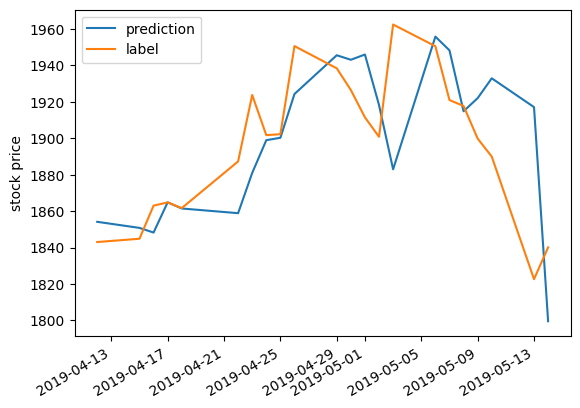

In [17]:
results.plot()
plt.ylabel("stock price")

Text(0, 0.5, 'Importance')

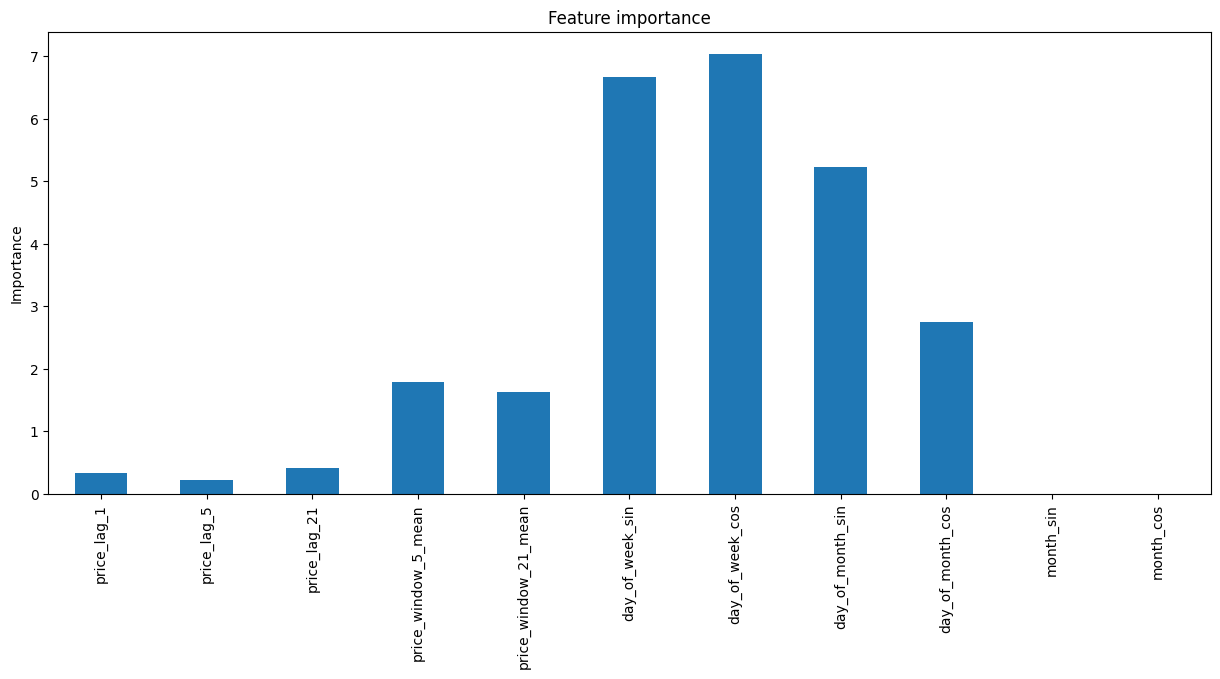

In [18]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(lasso.coef_))

# Let's add the variable names.
tmp.index = X_train_t.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

## XGBoost

In [27]:
date = []
prediction = []
label = []

for i in range(22, 0, -1):

  dataframe_c = AMZN_df.copy()

  pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)
  X_train, X_test, y_train, y_test = split_train_test(dataframe_c, i)
  X_train_t = pipe.fit_transform(X_train)
  X_test_t = pipe.transform(X_test)
  y_train_t = y_train.loc[X_train_t.index]
  y_test_t = y_test.loc[X_test_t.index]

  # XGboost regression

  xgbr = xgboost.XGBRegressor()

  # Train the model

  xgbr.fit(X_train_t, y_train_t)

  prediction.append(xgbr.predict(X_test_t)[0])

  label.append(y_test_t.iloc[-1][0])

  date.append(y_test_t.index[-1])

In [28]:
results_dict={"prediction":prediction, "label":label}
results = pd.DataFrame(results_dict, index=date)

In [29]:
r2_score(results.label, results.prediction)

0.3134541669684475

Text(0, 0.5, 'stock price')

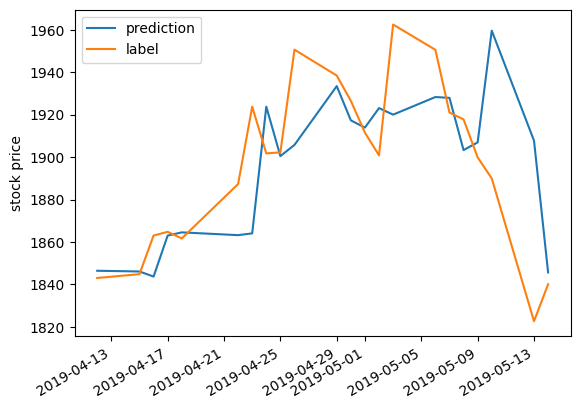

In [30]:
results.plot()
plt.ylabel("stock price")

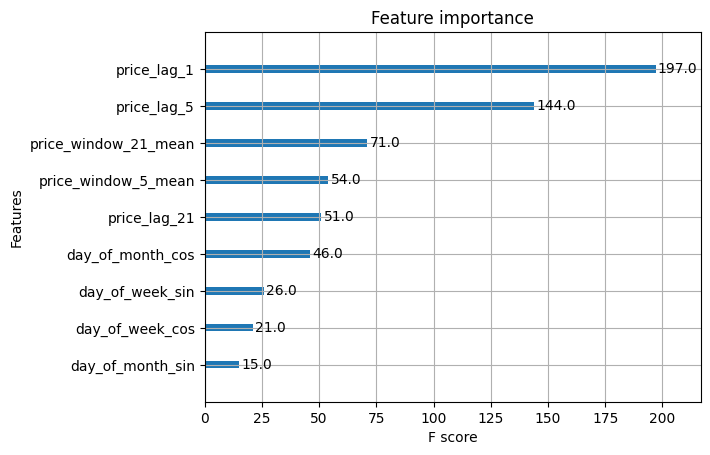

In [31]:
xgboost.plot_importance(xgbr, importance_type='weight')

plt.show()